In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from libs.tools import *
from libs.network import *
import torch
from geopy.distance import geodesic
from scipy import spatial
import copy
import seaborn as sns
from itertools import combinations
from scipy import spatial
from copy import deepcopy

/home/ids/yukliu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

### Preprocess for Dichasus/Opendata3 data

In [2]:
meta_data = pd.read_csv('./data/dichasus.csv')
# meta_data = pd.read_csv('./data/Opendata_3.csv') # another open dataset
csi_cols = [col for col in meta_data.columns if col not in ['Unnamed: 0', 'time', 'x', 'y']]
csi_data = meta_data[csi_cols].values
locations = meta_data[['x', 'y']].values

### Triplet fabrication

In [44]:
from offline_mining_tools import triplet_fabrication, triplet_hn_fabrication, triplet_fabrication_with_index
# opendata_triplets_by_distance = triplet_hn_fabrication(csi_data, locations, d=.3, dn=10, num_triplets=42000)
# np.save('./data/opendata_triplets_by_distance_05.npy', opendata_triplets_by_distance)

In [45]:
opendata_triplets, idx = triplet_fabrication_with_index(csi_data, locations, d=.3)

In [46]:
np.save('./data/opendata_triplets', opendata_triplets)
np.save('./data/opendata_triplets_idx', idx)

In [4]:
trip = np.load('./data/opendata_triplets.npy')
trip = np.load('./data/opendata_triplets_15000.npy')
trip_d = np.load('./data/opendata_triplets_by_distance_HN.npy')

### Pair fabrication

In [6]:
triplets = opendata_triplets

In [7]:
# triplets = np.swapaxes(trip, 0, 1)
# pair_anchor_idx = np.random.choice(len(triplets), len(triplets)//2)
pair_anchor_idx = range(len(triplets))
pair_anchors = np.array([triplets[pair_anchor_idx, 0, :], triplets[pair_anchor_idx, 1, :]])
pair_negs = np.array([triplets[pair_anchor_idx, 0, :], triplets[pair_anchor_idx, 2, :]])

new_pairs = np.concatenate([pair_anchors, pair_negs], axis=1)

In [8]:
a_idx = np.concatenate([idx[:, 0], idx[:, 0]])
pn_idx = np.concatenate([idx[:, 1], idx[:, 2]])
apn_idx = np.array([a_idx, pn_idx]).T

In [9]:
batch = apn_idx[0:256]
# Few shot data setting
num_dataset = len(locations)
size_data = num_dataset // 2
data_idx = np.random.choice(num_dataset, size_data)

In [14]:
ls = [1 if i in data_idx else 0 for i in batch]

/tmp/ipykernel_3286413/2543314548.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ls = [1 if i in data_idx else 0 for i in batch]


In [21]:
batch[0,0] in data_idx

False

In [15]:
sum(ls), sum(x_match)

(0, 103)

In [12]:
x_match = []
y_m = []
for i, j in batch:
    if i in data_idx:
        x_match.append(1)
    if j in data_idx:
        y_m.append(1)

In [14]:
siamese_pairs = np.swapaxes(new_pairs, 0, 1)

In [46]:
siamese_pairs.shape
# np.save('./data/opendata_pairs_with_idx.npy', siamese_pairs)
np.save('./data/opendata_pairs_idx.npy', apn_idx)

In [18]:
num_pair = 50000
idx_pair_1 = np.random.choice(len(csi_data), num_pair)
idx_pair_2 = np.random.choice(len(csi_data), num_pair)
tmp = np.array([csi_data[idx_pair_1], csi_data[idx_pair_2]]).T
tmp = np.swapaxes(tmp, 0, 1)
tmp = np.swapaxes(tmp, 1, 2)

In [5]:
d_f = np.linalg.norm(csi_data[idx_pair_1]-csi_data[idx_pair_2], axis=1)**2
d_e = np.linalg.norm(locations[idx_pair_1] - locations[idx_pair_2], axis=1)**2

Text(0, 0.5, 'Euclidean distance between features')

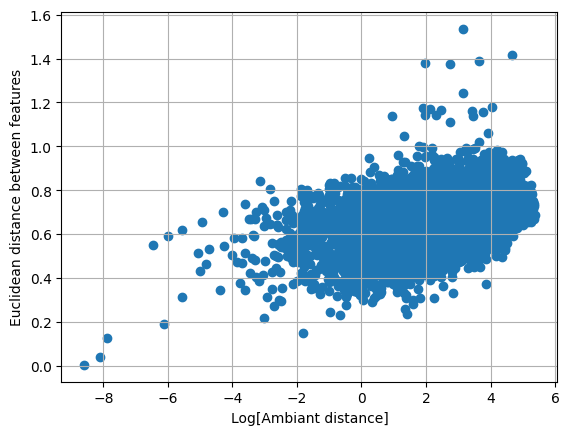

In [7]:
plt.scatter(np.log(d_e), d_f)
plt.grid()
plt.xlabel('Log[Ambiant distance]')
plt.ylabel('Euclidean distance between features')
# plt.savefig('./result/log_ambiant_feature_relation.pdf')

### Time-locations analyzation

In [4]:
csi_time = meta_data['time']
NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
nmlz_time = NormalizeData(csi_time)

In [5]:
sorted_xy = meta_data.sort_values('time')[['x', 'y', 'time']][:1000]
xy = sorted_xy[['x', 'y']].values
time = sorted_xy['time'].values

In [10]:
xy_comb = np.array(list(combinations(xy, 2)))
time_comb = np.array(list(combinations(time, 2)))
dist = np.linalg.norm(xy_comb[:, 0] - xy_comb[:, 1], axis=1)
dt = abs(time_comb[:, 0] - time_comb[:, 1])

In [13]:
tmp = pd.DataFrame()
tmp['time_difference [s]'] = dt
tmp['distance_difference [m]'] = dist
sns.lineplot(data=tmp, x='time_difference [s]', y='distance_difference [m]')


<Axes: xlabel='time_difference [s]', ylabel='distance_difference [m]'>

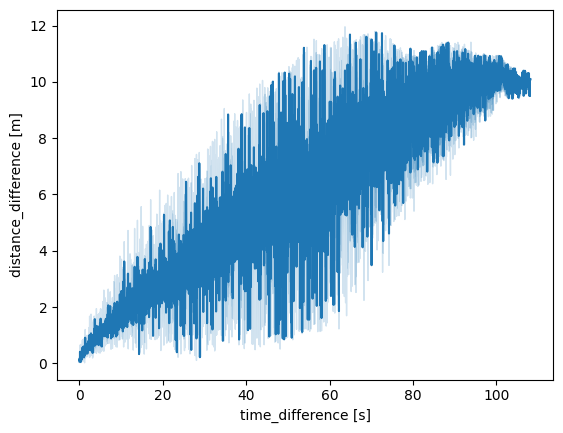

In [14]:
sns.lineplot(data=tmp, x='time_difference [s]', y='distance_difference [m]')
# plt.savefig('./result/time_distance_analysis.pdf')

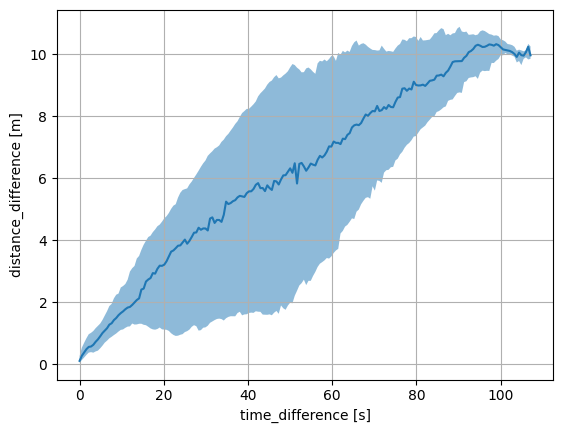

In [17]:
distances_flat = dt
dissimilarities_flat = dist
max_distance = np.max(distances_flat)
bins = np.linspace(0, max_distance, 200)
bin_indices = np.digitize(distances_flat, bins)

bin_medians = np.zeros(len(bins) - 1)
bin_25_perc = np.zeros(len(bins) - 1)
bin_75_perc = np.zeros(len(bins) - 1)
for i in range(1, len(bins)):
    try:
        bin_values = dissimilarities_flat[bin_indices == i]
        bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
    except:
        break

end = -10
plt.plot(bins[:i-1], bin_medians[: i-1], label = 'Metric distance')
plt.fill_between(bins[:i-1], bin_25_perc[:i-1], bin_75_perc[:i-1], alpha=0.5)
plt.xlabel('time_difference [s]')
plt.ylabel('distance_difference [m]')
plt.grid()
# plt.savefig('./result/embedding_distance_relation.pdf')
plt.savefig('./result/time_distance_analysis_ci.pdf')

# Preprocess for Opendata 2

In [4]:
meta_data = pd.read_csv('./data/Opendata_2.csv')
csi_cols = [col for col in meta_data.columns if col not in ['Unnamed: 0', 'x', 'y']]
csi_data = meta_data[csi_cols].values
locations = meta_data[['x', 'y']].values

# Preprocess for Simulated data

In [23]:
used_data = dataHandler(header='/home/ids/yukliu/Test/', city='London', mode=0)

# train_data, test_data = train_test_split(used_data, train_size=.75, random_state=24)
target_cols = ['Lat', 'Lon']
csi_cols = [col for col in used_data.columns if col not in [target_cols, 'city']]
csi_data = used_data[csi_cols].values
locations = used_data[target_cols].values

# Load Model

In [3]:
from libs.network import *

In [6]:
bs = 256
embed_dim = 2
# suffix_p = 'Pairs_simple'
# suffix_p = 'Pairs_middle_big_with_idx'
suffix_p = 'Pairs_few_shot_5'

# hiddens_p = [512, 256, 128, 64, 32, 16, 8, 4, 2]
hiddens_p = [512, 256, 128, 64, 32, 16]
embedding_net = ANN(1024, 2, hiddens=hiddens_p)
pair_net = PairNet(embedding_net)
pair_net.load_state_dict(torch.load(f'../checkpoints/Pairnet_emb_{embed_dim}_bs_{bs}_{suffix_p}.sav'))

<All keys matched successfully>

### Pair network
loss = $(\|x-y\|-\|f(x)-f(y)\|)^2$

In [39]:
csi_tensor = torch.FloatTensor(csi_data)
cc_pair = pair_net.get_embedding(csi_tensor)
cc_arr_pair = cc_pair.detach().numpy()

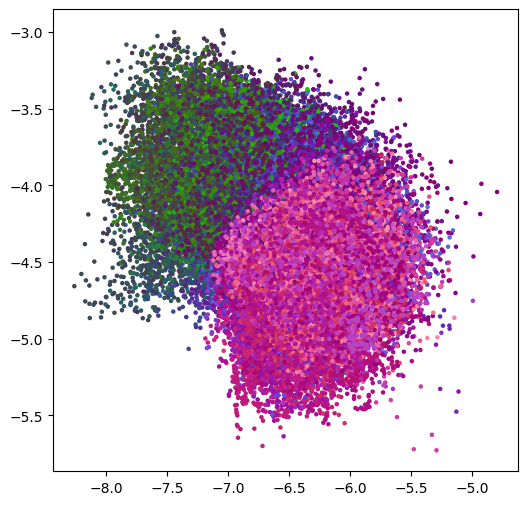

In [40]:
plot_colorized(locations, cc_arr_pair)
# plt.savefig('./result/siamese_cc_few_shot.pdf')

#### Pair network evaludation: csi distance vs embedding distance

In [16]:
rd_idx = np.random.choice(len(csi_data), 1000)
cc_pair_rd = cc_arr_pair[rd_idx]
csi_rd = csi_data[rd_idx]

cc_pair_combine = np.array(list(combinations(cc_pair_rd, 2)))
csi_combine = np.array(list(combinations(csi_rd, 2)))

In [21]:
d_pair = np.linalg.norm(cc_pair_combine[:, 0]-cc_pair_combine[:, 1], axis=1)
d_csi = np.linalg.norm(csi_combine[:, 0]-csi_combine[:, 1], axis=1)

Text(0, 0.5, 'CSI euclidean distance')

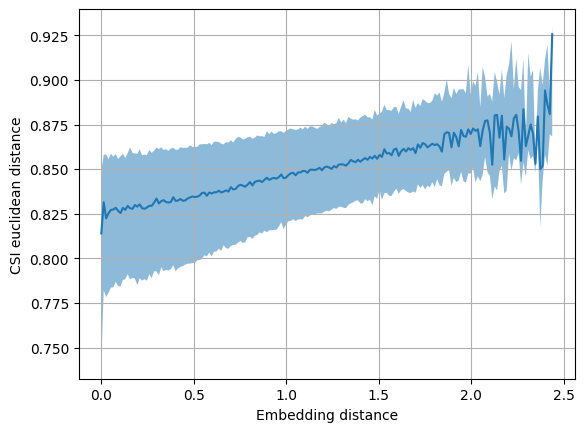

In [27]:
from offline_mining_tools import draw_ci_plot


draw_ci_plot(d_pair, d_csi)
plt.xlabel('Embedding distance')
plt.ylabel('CSI euclidean distance')
plt.savefig('./result/siamese_distance.pdf')

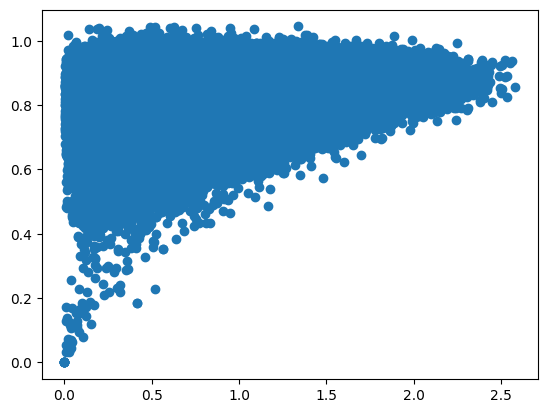

In [28]:
plt.scatter(d_pair, d_csi)

## Triplet network

In [7]:
bs = 256
embed_dim = 2

suffix = 'OpenDataTest_OfflineMining_new'
suffix_distance_03 = 'OpenDataTest_OfflineMining_Distance03'
suffix_distance_04 = 'OpenDataTest_OfflineMining_Distance04'
suffix_distance_05 = 'OpenDataTest_OfflineMining_Distance05'

In [71]:
suffix = 'Triplet_few_shot_2' # few shot suffix
suffix = 'OpenDataTest_OfflineMining_new'


In [4]:
dim_1 = 1024
dim_2 = 1053
# hiddens=[512, 256, 128, 64, 32, 16] # [512, 256, 128, 64]
hiddens = [512, 256, 128, 64]
# hiddens = [512, 256, 128, 64, 32, 16, 8, 4, 2]
embedding_net = ANN(dim_1, 2, hiddens=hiddens)
triplet_net = TripletNet(embedding_net)
# triplet_net_distance_03 = deepcopy(triplet_net)
# triplet_net_distance_04 = deepcopy(triplet_net)
# triplet_net_distance_05 = deepcopy(triplet_net)

In [38]:
triplet_net.load_state_dict(torch.load(f'/home/ids/yukliu/checkpoints/Triplet_emb_2_m_2_bs_{bs}_{suffix}.sav'))


<All keys matched successfully>

In [39]:
# triplet_net.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_2_m_2_bs_{bs}_{suffix}.sav'))
# triplet_net_distance_03.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_2_m_2_bs_{bs}_{suffix_distance_03}.sav'))
# triplet_net_distance_04.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_2_m_2_bs_{bs}_{suffix_distance_04}.sav'))
# triplet_net_distance_05.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_2_m_2_bs_{bs}_{suffix_distance_05}.sav'))

In [40]:
csi_tensor = torch.FloatTensor(csi_data)
cc = triplet_net.get_embedding(csi_tensor)
cc_arr = cc.detach().numpy()

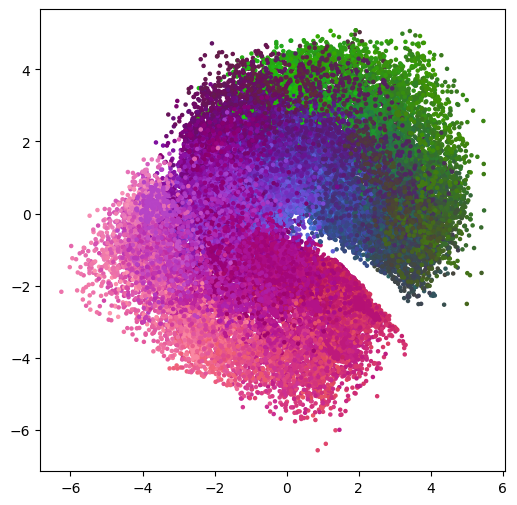

In [41]:
plot_colorized(locations, cc_arr)
# plt.savefig('./result/triplet_few_shot.pdf')

In [63]:
cc_distance_03 = triplet_net_distance_03.get_embedding(csi_tensor)
cc_arr_distance_03 = cc_distance_03.detach().numpy()

In [64]:
cc_distance_04 = triplet_net_distance_04.get_embedding(csi_tensor)
cc_arr_distance_04 = cc_distance_04.detach().numpy()

In [52]:
cc_distance_05 = triplet_net_distance_05.get_embedding(csi_tensor)
cc_arr_distance_05 = cc_distance_05.detach().numpy()

# Embedding distance vs euclidean distance

In [16]:
from offline_mining_tools import distance_ci_visualization

In [31]:
num = 20000
d_ls = []
c_ls = []
for i in range(num):
    ids = np.random.choice(len(cc_arr), 2)
    c1, c2 = cc_arr[ids[0]], cc_arr[ids[1]]
    metric_d = np.linalg.norm(c1-c2)
    d = np.linalg.norm(locations[ids[0]]-locations[ids[1]])
    d_ls.append(d)
    c_ls.append(metric_d)

In [40]:
num = 20000
d_ls_distance = []
c_ls_distance = []
for i in range(num):
    ids = np.random.choice(len(cc_arr_distance_05), 2)
    c1, c2 = cc_arr_distance_05[ids[0]], cc_arr_distance_05[ids[1]]
    metric_d = np.linalg.norm(c1-c2)
    d = np.linalg.norm(locations[ids[0]]-locations[ids[1]])
    d_ls_distance.append(d)
    c_ls_distance.append(metric_d)

In [33]:
def distance_ci_visualization(distances_flat, dissimilarities_flat):
    max_distance = np.max(distances_flat)
    bins = np.linspace(0, max_distance, 200)
    bin_indices = np.digitize(distances_flat, bins)

    bin_medians = np.zeros(len(bins) - 1)
    bin_25_perc = np.zeros(len(bins) - 1)
    bin_75_perc = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        try:
            bin_values = dissimilarities_flat[bin_indices == i]
            bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
        except:
            break

    return bins[:i-1], bin_medians[: i-1], bin_25_perc[:i-1], bin_75_perc[:i-1]


In [34]:
bins, medians, perc_25, perc_75 = distance_ci_visualization(np.array(d_ls), np.array(c_ls))

In [41]:
bins_d, medians_d, perc_25_d, perc_75_d = distance_ci_visualization(np.array(d_ls_distance), np.array(c_ls_distance))

In [43]:
dict_metric = np.load('./data/metric_distance_dist.npy', allow_pickle=True).item()


In [45]:
bins_metric, medians_metric, perc_25_metric, perc_75_metric = dict_metric.values()

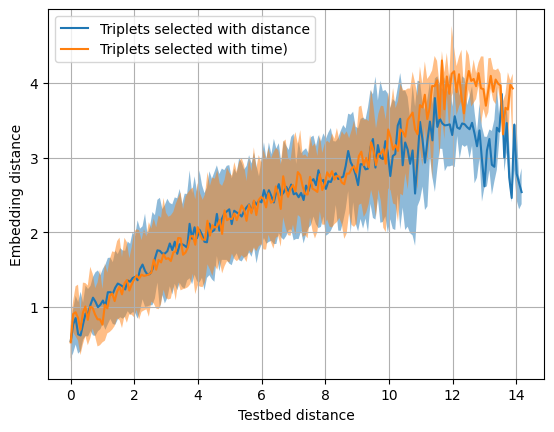

In [70]:
plt.plot(bins_d, medians_d, label = 'Triplets selected with distance')
plt.fill_between(bins_d, perc_25_d, perc_75_d, alpha=0.5)

plt.plot(bins, medians, label = 'Triplets selected with time)')
plt.fill_between(bins, perc_25, perc_75, alpha=0.5)

# plt.plot(bins_metric, medians_metric, label = 'Metric distance (by metric learning)')
# plt.fill_between(bins_metric, perc_25_metric, perc_75_metric, alpha=0.5)
plt.xlabel('Testbed distance')
plt.ylabel('Embedding distance')
plt.grid()
plt.legend()
plt.savefig('./result/metric_time_and_distance.pdf')

In [59]:
dic = {}
dic['bins'] = bins_d
dic['medians'] = medians_d
dic['25'] = perc_25_d
dic['75'] = perc_75_d

# np.save('./data/triplet_distance_dist_hn', dic, allow_pickle=True)

### Dimension reduction evaluation

In [20]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold
import random


In [41]:
def kruskal_stress(X, X_embedded, *, metric="euclidean"):
	dist_X = pairwise_distances(X, metric = metric)
	dist_X_embedded = pairwise_distances(X_embedded, metric = metric)
	beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

	return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

def continuity(*args, **kwargs):
    args = list(args)
    args[0], args[1] = args[1], args[0]
    return manifold.trustworthiness(*args, **kwargs)

In [57]:
subset_indices = random.sample(range(len(locations)), len(locations) // 10)

locations_subset = locations[subset_indices]
cc_subset = cc_arr[subset_indices]
# cc_disance_subset = cc_arr_distance_04[subset_indices]

In [58]:
continuity(locations_subset, cc_subset), kruskal_stress(locations_subset, cc_subset), manifold.trustworthiness(locations_subset, cc_subset)

(0.9245337128762692, 0.4241921750062016, 0.8752323515688621)

In [59]:
continuity(locations_subset, cc_subset), kruskal_stress(locations_subset, cc_subset), manifold.trustworthiness(locations_subset, cc_subset)

(0.7239647394202378, 0.5400420801609306, 0.6644822036401958)

#### Continuous Route Tracking

In [44]:
graph = create_graph(locations)
start_point, end_point = locations[:, 0].argmax(), locations[:, 0].argmin()
start_point = 100
shortest_path = dijkstra(graph, start_point, end_point)


In [46]:
cc_route = cc_arr[shortest_path]

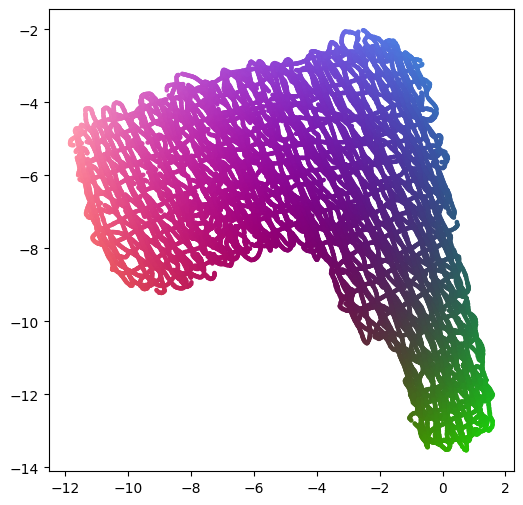

In [45]:
plot_colorized(locations, locations)
# plt.savefig('./result/experimental_space.pdf')

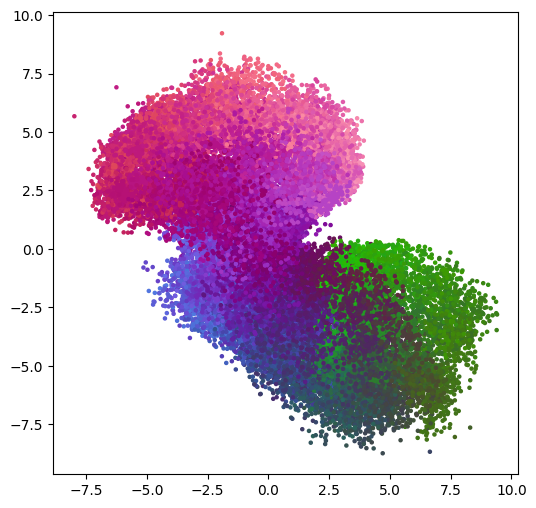

In [99]:
plot_colorized(locations, cc_arr_distance)


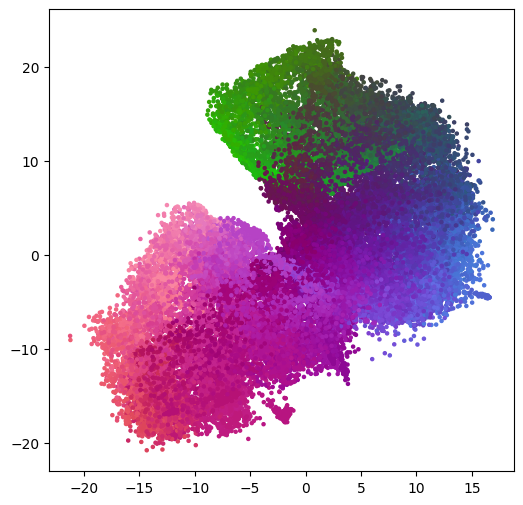

In [98]:
plot_colorized(locations, cc_arr)
# plt.savefig('./result/embedding_space.pdf')
# plot_agent(cc_route)

In [51]:
def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

In [52]:
cc_af = affine_transform_channel_chart(locations, cc_arr)

### Representation evaluation

In [33]:
from sklearn import manifold

# Localisation with Channel Charting

In [44]:
from sklearn.neighbors import KNeighborsRegressor

In [45]:
d_fn = np.linalg.norm

In [46]:
def localisation_cc(cc, pos, n_neigh=5, geo=False):
    cc_train, cc_test, pos_train, pos_test = train_test_split(cc, pos, random_state=24)
    knr = KNeighborsRegressor(n_neighbors=n_neigh)
    knr.fit(cc_train, pos_train)

    pos_pred = knr.predict(cc_test)
    if geo:
        dist_err = dist_from_geo(pos_pred, pos_test)
    else:
        dist_err = d_fn(pos_pred - pos_test, axis=1)


    e_bar = np.quantile(dist_err, .9)
    anomlies = pos_test[dist_err>e_bar]
    return dist_err, pos_test


In [65]:
cc_mds = np.load('./data/mds_out.npy')
e_siamese, _ = localisation_cc(cc_arr_pair, locations, n_neigh=100)
e_triplet, _ = localisation_cc(cc_arr_distance_03, locations, n_neigh=100)
e_mds, _ = localisation_cc(cc_mds, locations, n_neigh=100)

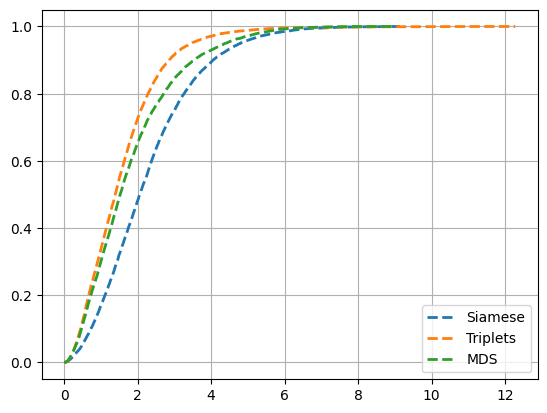

In [67]:
cdf_plot(e_siamese)
cdf_plot(e_triplet)
cdf_plot(e_mds)
# cdf_plot(err_bm)
# cdf_plot(err_autogluon)
plt.legend(['Siamese', 'Triplets', 'MDS'])
plt.grid()
plt.savefig('./result/siamese_triplets_compare.pdf')

In [27]:
e0, a0 = localisation_cc(locations, locations)

In [30]:
e1, a1 = localisation_cc(cc_arr, locations)


In [32]:
e1, a1 = localisation_cc(cc_arr, locations)
e2, a2 = localisation_cc(cc_arr_distance_04, locations)
e3, a3 = localisation_cc(cc_arr_distance_05, locations)
e4, a4 = localisation_cc(cc_arr_distance_04, locations)


In [132]:
idx = np.random.choice(len(e1), 5000)

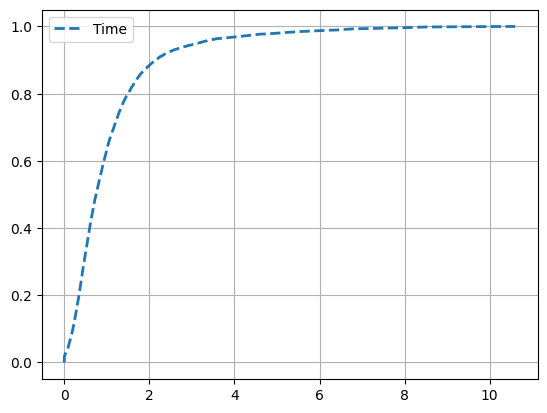

In [34]:
cdf_plot(e1)
# cdf_plot(e2)
# cdf_plot(e3)
# cdf_plot(e4)
plt.legend(['Time', 'Distance - 04', 'Distance - 05', 'Distance - 03'])
plt.grid()

In [37]:
err_16 = localisation_cc(cc_arr, locations, n_neigh=5)

In [23]:
err_dist = localisation_cc(cc_arr, locations, n_neigh=5)

In [38]:
err_auto_knn = localisation_cc(csi_data, locations, n_neigh=5)

In [17]:
d = np.load('./data/dist_err_autogluon_OpenData_Autogluon.npy')

In [66]:
err = np.load('./data/dist_err_distance_opendata.npy')
err_autogluon = np.load('../data/dist_err_autogluon_OpenData_Autogluon.npy')
err_bm = np.load('./data/opendata_benchmark.npy')
err_metric = np.load('./data/dist_err_metric_learning.npy')
# np.load('./data/')

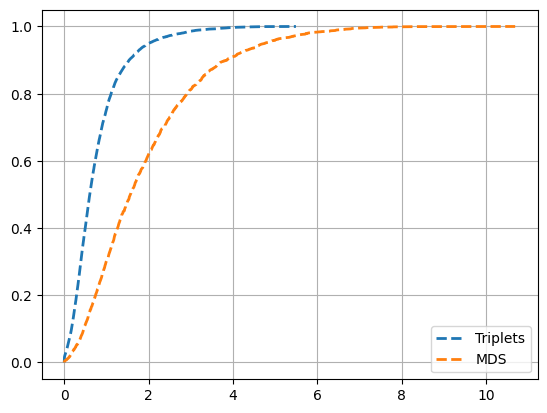

In [24]:
cdf_plot(err_bm)
cdf_plot(e_mds)
plt.grid()
plt.legend(['Triplets', 'MDS'])

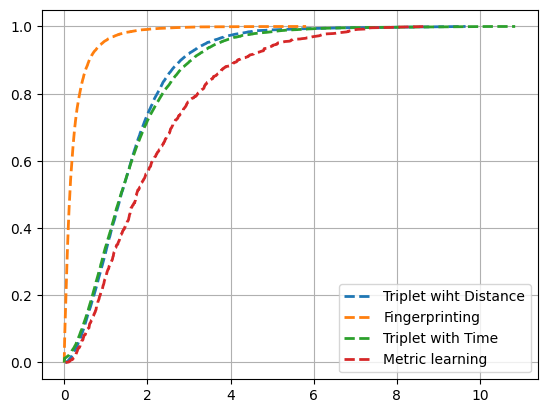

In [71]:
# cdf_plot(err)
# cdf_plot(err_bm)
cdf_plot(e2)
cdf_plot(err_autogluon)
cdf_plot(e1)
# cdf_plot(err_dist)
cdf_plot(err_metric)
plt.legend(['Triplet with Distance', 'Fingerprinting', 'Triplet with Time', 'Metric learning'])
plt.grid()
# plt.savefig('./result/metric_learning_res_new.pdf')

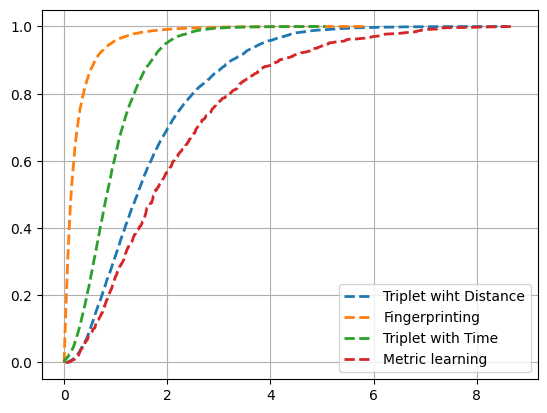

In [69]:
# cdf_plot(err)
# cdf_plot(err_bm)
cdf_plot(e2)
cdf_plot(err_autogluon)
cdf_plot(e1)
# cdf_plot(err_dist)
cdf_plot(err_metric)
plt.legend(['Triplet wiht Distance', 'Fingerprinting', 'Triplet with Time', 'Metric learning'])
plt.grid()
# plt.savefig('./result/metric_learning_res.pdf')

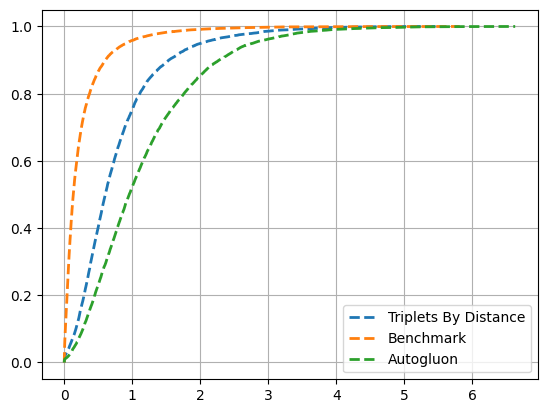

In [44]:
cdf_plot(err_16)
# cdf_plot(err_bm)
cdf_plot(err_autogluon)
cdf_plot(err_dist)
# cdf_plot(err_auto_knn)

plt.grid()
# plt.legend(['Triplets By Distance', 'Benchmark', 'Autogluon', f'Triplet wiht embed_dim {embed_dim}'])
plt.legend(['Triplets By time', 'Triplets By distance', 'Autogluon'])

# MDS

In [ ]:
mds_cc = np.load('./data/mds_out.npy')
e_mds, _ = localisation_cc(mds_cc, locations)

In [21]:
idx = np.random.choice(len(csi_data), size=10000)

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
out = model.fit_transform(csi_data[idx])

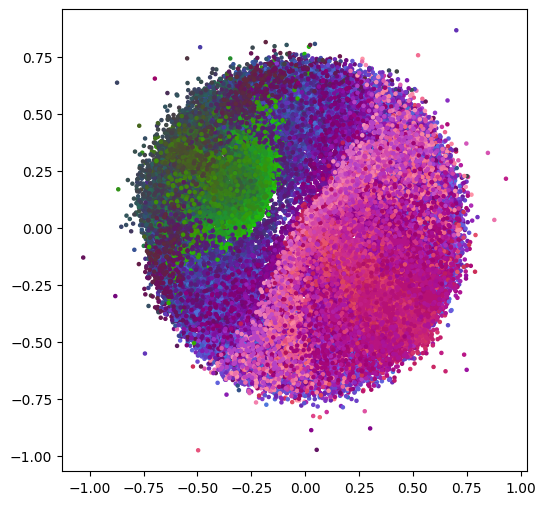

In [31]:
plot_colorized(locations, cc_mds)
plt.savefig('./result/mds_cc_2.pdf')

In [19]:
e_mds, _ = localisation_cc(out, locations[idx])

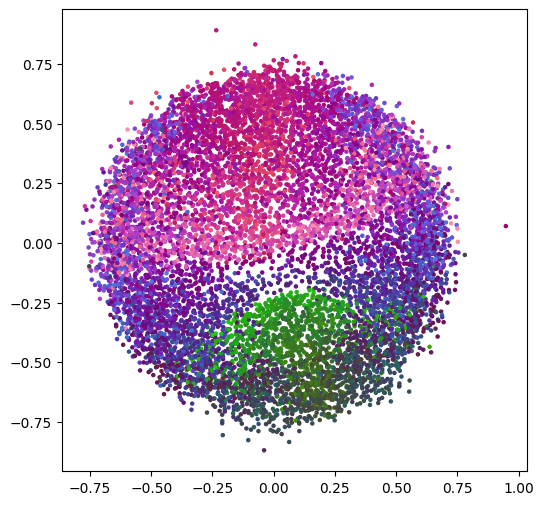

In [35]:
plot_colorized(locations[idx], out)
# plt.savefig('./result/mds_cc.pdf')

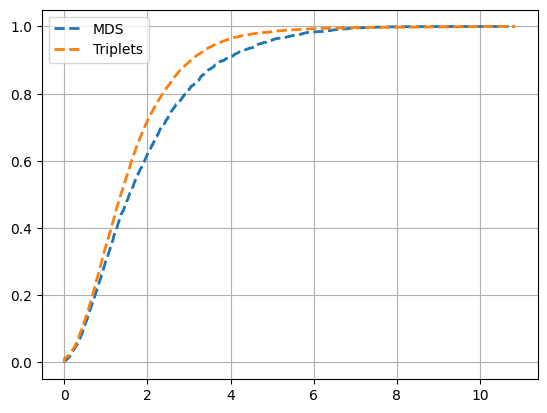

In [36]:
cdf_plot(e_mds)
cdf_plot(e1)
plt.legend(['MDS', 'Triplets'])
plt.grid()
plt.savefig('./result/mds_triplet_compare.pdf')

## PCA, ISOMAP

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from scipy.sparse import lil_matrix

In [46]:
lil_csi = lil_matrix(csi_data)

In [5]:
lil_csi.get_shape()

(10000, 1053)

In [10]:
pca = PCA(n_components=2)
pca.fit(csi_data.T)

PCA(n_components=2)

In [52]:
isomap = Isomap(n_components=2)
iso_embedding = isomap.fit_transform(csi_data)

In [11]:
pca_cc = pca.components_.T

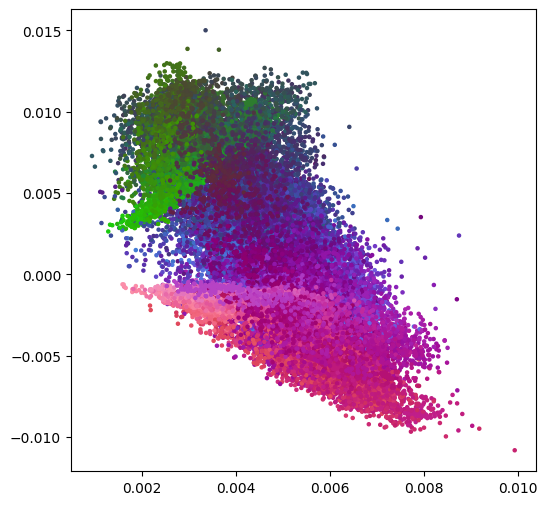

In [12]:
plot_colorized(locations, pca_cc)

In [13]:
pca_err = localisation_cc(pca_cc, locations, geo=0)
# iso_err = localisation_cc(iso_embedding, locations, geo=1)

In [26]:
cp = sns.color_palette('bright', 5)

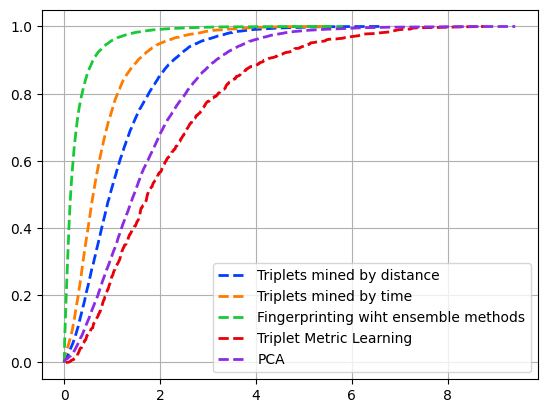

In [27]:
cdf_plot(err, c=cp[0])
cdf_plot(err_bm, c=cp[1])
cdf_plot(err_autogluon, c=cp[2])
cdf_plot(err_metric, c=cp[3])
cdf_plot(pca_err, c=cp[4])
plt.legend(['Triplets mined by distance', 
             'Triplets mined by time',  
             'Fingerprinting wiht ensemble methods',
             'Triplet Metric Learning', 'PCA'])
# cdf_plot(iso_err)
# plt.legend(['Triplets mined by distance', 'Triplets mined by time', 'Autogluon', 'PCA', 'Isomap'])
plt.grid()
plt.savefig('./result/cdf_all.pdf')
# plt.savefig('./result/cdf_compare.pdf')